# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [41]:
import os
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
from groq import Groq


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [42]:
from tqdm import tqdm
from PyPDF2 import PdfReader
import glob

# load the pdf from the path
glob_path = "data/*.pdf"
text = ""

for pdf_path in tqdm(glob.glob(glob_path)):
    with open(pdf_path, "rb") as file:
        print(file)
        reader = PdfReader(file)
        # Extract text from all pages in the PDF
        text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())

# Vorschau der ersten 50 Zeichen
text[:50]


 11%|█         | 1/9 [00:00<00:01,  6.87it/s]

<_io.BufferedReader name='data/02_Merkblatt_Vermeidung-von-Plagiaten_0916.pdf'>
<_io.BufferedReader name='data/05_Checkliste_Sprachliche_Formale_Ausarbeitung.pdf'>


 33%|███▎      | 3/9 [00:00<00:00, 12.23it/s]

<_io.BufferedReader name='data/Bibliotheksangebot_Bachelorarbeit_HS24FS25.pdf'>
<_io.BufferedReader name='data/Schwerpunktthemen_fuer_Studenten.pdf'>
<_io.BufferedReader name='data/W_MB_Merkblatt_Bachelorarbeit_BSc.pdf'>


 56%|█████▌    | 5/9 [00:02<00:02,  1.95it/s]

<_io.BufferedReader name='data/ZHAW_Zitierleitfaden_DE.pdf'>


 67%|██████▋   | 6/9 [00:02<00:01,  1.65it/s]

<_io.BufferedReader name='data/Z_MB_Merkblatt_Verwendung_von_generativer_KI_in_Arbeiten.pdf'>


 78%|███████▊  | 7/9 [00:03<00:01,  1.60it/s]

<_io.BufferedReader name='data/Z_RL_Richtlinie_Anhang_Deklarationspflicht_KI_bei_Arbeiten.pdf'>


 89%|████████▉ | 8/9 [00:04<00:00,  1.79it/s]

<_io.BufferedReader name='data/Z_RL_Richtlinie_KI_bei_Leistungsnachweisen.pdf'>


100%|██████████| 9/9 [00:04<00:00,  2.05it/s]


' \n \n \n \n \n \n2.2.5.1 -01MB Vermeidung von Plagiaten'

## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter, in this case [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/),  to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.

In [43]:
# Import necessary libraries
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import CharacterTextSplitter
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
# Split the extracted text into manageable chunks
chunks = splitter.split_text(text)

In [44]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 61
Preview of the first chunk: 2.2.5.1 -01MB Vermeidung von Plagiaten  Dok.- Verantw.:  mart 
Version 2.0   
. 
Genehmigt  19.9.12  durch: Generalsekretär   Seite 1 von 2 
 Rektorat  
 
Ressort Lehre  
 
Merkblatt zur Vermeidung vo


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model (see [SentenceTransformersTokenTextSplitter](https://python.langchain.com/api_reference/text_splitters/sentence_transformers/langchain_text_splitters.sentence_transformers.SentenceTransformersTokenTextSplitter.html#sentencetransformerstokentextsplitter)).

In [45]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [46]:
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 252
2.2.5.1 -01MB Vermeidung von Plagiaten Dok.- Verantw.: mart Version 2.0 . Genehmigt 19.9.12 durch: Generalsekretär Seite 1 von 2 Rektorat Ressort Lehre Merkblatt zur Vermeidung von Plagiaten Plagiate verstossen gegen grundlegende Regeln wissenschaftlichen Arbeitens. Entsprechend s e- hen das Gesetz und die Rahmenprüfungsordnung für Bachelor - und Masterstudi engänge der ZHAW (RPO) in Plagiatsfällen zum Teil gravierende Sanktionen für Studierende vor. Dieses Mer k- blatt soll 


In [47]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁2.2', '.', '5.1', '▁', '-01', 'MB', '▁Verme', 'i', 'dung', '▁von', '▁Pla', 'gia', 'ten', '▁Dok', '.', '-', '▁Ver', 'ant', 'w', '.', ':', '▁mart', '▁Version', '▁2.0', '▁', '.', '▁Ge', 'nehm', 'igt', '▁19', '.9.', '12', '▁durch', ':', '▁General', 'sekretär', '▁Seite', '▁1', '▁von', '▁2', '▁Rektor', 'at', '▁Res', 'sort', '▁Lehr', 'e', '▁Merk', 'blatt', '▁zur', '▁Verme', 'i', 'dung', '▁von', '▁Pla', 'gia', 'ten', '▁Pla', 'gia', 'te', '▁vers', 'to', 'ssen', '▁gegen', '▁grundlegende', '▁Regeln', '▁', 'wissenschaftlich', 'en', '▁Arbeiten', 's', '.', '▁Ent', 'sprechen', 'd', '▁s', '▁e', '-', '▁hen', '▁das', '▁Gesetz', '▁und', '▁die', '▁Rahmen', 'prüfung', 's', 'ordnung', '▁für', '▁Bachelor', '▁-', '▁und', '▁Master', 'studi', '▁en', 'gänge', '▁der', '▁Z', 'HA', 'W', '▁(', 'R', 'PO', ')', '▁in', '▁Pla', 'gia', 'ts', 'fälle', 'n', '▁zum', '▁Teil', '▁gravi', 'erende', '▁San', 'ktion', 'en', '▁für', '▁Studi', 'erende', '▁vor', '.', '▁Dieses', '▁Mer', '▁k', '-', '▁', 'blatt', '</s

In [48]:
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['[CLS]', '2', '.', '2', '.', '5', '.', '1', '-', '01', '##MB', 'Vermeidung', 'von', 'Pla', '##gia', '##ten', 'Dok', '.', '-', 'Veran', '##tw', '.', ':', 'mar', '##t', 'Version', '2', '.', '0', '.', 'Genehm', '##igt', '19', '.', '9', '.', '12', 'durch', ':', 'Generalsekretär', 'Seite', '1', 'von', '2', 'Rektor', '##at', 'Ressort', 'Lehre', 'Merk', '##blatt', 'zur', 'Vermeidung', 'von', 'Pla', '##gia', '##ten', 'Pla', '##gia', '##te', 'verst', '##ossen', 'gegen', 'grundlegende', 'Regeln', 'wissenschaft', '##lichen', 'Arbeiten', '##s', '.', 'Entsprechend', 's', 'e', '-', 'hen', 'das', 'Gesetz', 'und', 'die', 'Rahmen', '##prüfung', '##sor', '##dn', '##ung', 'für', 'Bachelor', '-', 'und', 'Masters', '##tu', '##di', 'eng', '##änge', 'der', 'Z', '##H', '##AW', '(', 'R', '##PO', ')', 'in', 'Pla', '##gia', '##ts', '##fällen', 'zum', 'Teil', 'grav', '##ierende', 'Sanktionen', 'für', 'Studierende', 'vor', '.', 'Dieses', 'Mer', 'k', '-', 'bl', '##att', 'soll', '[SEP]']
Chunk 1: ['[CLS]',

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [49]:
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.

In [50]:
d = chunk_embeddings.shape[1]
print(d)

1024


In [51]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 252


In [52]:
if not os.path.exists('faiss'):
    os.makedirs('faiss')
    
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [53]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

61
252


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [54]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [55]:
def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [56]:
def retrieve(query, k=5):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

In [57]:
query = "KI während der Bachelorarbeit"
results, result_embeddings, distances = retrieve(query, k=3)
print("Retrieved document preview:")
print(results[0][:300])

Retrieved document preview:
(2012). Die Chefs von morgen: Kompetent und kritisch. io Management, 2012(5), 12-15. Zitierleitfaden | 19 Zitierleitfaden | 20 Generative Systeme, die auf Künstlicher Intelligenz (KI) basieren, gehören zunehmend zur neuen Studien- und Berufsrealität von Lehrenden und Lernenden. Die Richtlinie KI bei


In [58]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warning

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

Projecting Embeddings:   0%|          | 0/252 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.

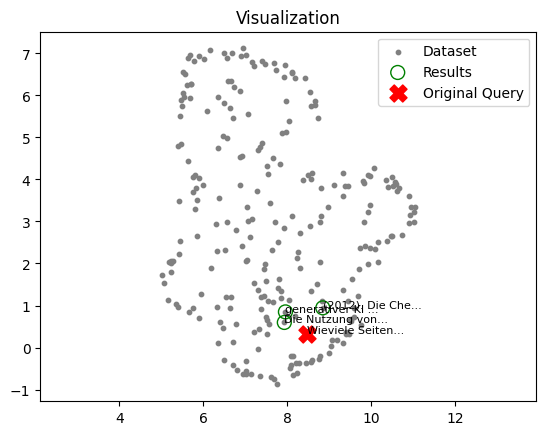

In [59]:

# Project the full dataset embeddings if not already done
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Welche hilfsmittel sind erlaubt?'  # Replace with your actual query text if needed
original_query_text = 'Wieviele Seiten muss die Arbeit sein?'  # Replace with your actual query text if needed

plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Visualization')
plt.legend()
plt.show()


---

# 📝 Task: Semantic Retrieval-Augmented Question Answering Using Groq LLM

## Objective
Implement a question-answering system that:
1. Retrieves the most semantically relevant text passages to a user query.
2. Constructs a natural language prompt based on the retrieved content.
3. Uses a large language model (LLM) hosted by Groq to generate an answer.

---

## Task Breakdown

### 1. Embedding-Based Semantic Retrieval
- Use the `SentenceTransformer` model `"Sahajtomar/German-semantic"` to encode a user query into a dense vector embedding.
- Perform a nearest-neighbor search in a prebuilt FAISS index to retrieve the top-**k** similar text chunks. You can **use the prebuilt FAISS form above**.


### 2. LLM Prompt Construction and Query Answering
- Build the prompt:
  - Using the retrieved text chunks, concatenates the results into a context block.
  - Builds a **prompt** asking the LLM to answer the question using that context.
  - Sends the prompt to the **Groq LLM API** (`llama-3.3-70b-versatile`) and returns the response.

### 3. User Query Execution
- An example query (`"What is the most important factor in diagnosing asthma?"`) is used to demonstrate the pipeline.
- The final answer from the LLM is printed.


## Tools & Models Used
- **SentenceTransformers** (`Sahajtomar/German-semantic`) for embedding generation.
- **FAISS** for efficient vector similarity search.
- **Groq LLM API** (`llama-3.3-70b-versatile`) for generating the final response.


In [61]:
# Optimiertes RAG-System für Bachelorarbeit-Beratung (ZHAW)
# Version 3.0 - Mai 2025

import os
import time
import json
import faiss
import pickle
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Any, Optional
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
from colorama import Fore, Style, init

# Colorama initialisieren
init(autoreset=True)

try:
    from groq import Groq
except ImportError:
    Groq = None

class OptimizedRAGSystem:
    def __init__(
        self,
        api_key_path: str = "env.txt",
        embedding_model_name: str = "Sahajtomar/German-semantic",
        llm_model_name: str = "llama-3.3-70b-versatile",
        faiss_index_path: str = "faiss/faiss_index.index",
        chunks_mapping_path: str = "faiss/chunks_mapping.pkl",
        log_path: str = "logs",
        cache_path: str = "cache",
        fallback_to_sample: bool = True
    ):
        self.embedding_model_name = embedding_model_name
        self.llm_model_name = llm_model_name
        self.faiss_index_path = faiss_index_path
        self.chunks_mapping_path = chunks_mapping_path
        self.log_path = log_path
        self.cache_path = cache_path
        self.fallback_to_sample = fallback_to_sample

        self.sample_chunks = [
            "KI kann während der Bachelorarbeit als nützliches Tool eingesetzt werden, um Literaturrecherche zu unterstützen.",
            "Die Formatierung der Bachelorarbeit folgt den Vorgaben der Universität und sollte konsistent sein.",
            "Eine Bachelorarbeit umfasst typischerweise zwischen 40 und 60 Seiten, abhängig von den spezifischen Anforderungen.",
            "Beim Schreiben der Bachelorarbeit ist auf wissenschaftliche Sprache und korrekte Zitation zu achten.",
            "Die Gliederung einer Bachelorarbeit umfasst typischerweise: Einleitung, Hauptteil, Fazit und Literaturverzeichnis.",
            "Generative KI-Systeme müssen in der Bachelorarbeit ordnungsgemäß deklariert werden gemäß ZHAW-Richtlinien.",
            "Die ZHAW verlangt eine Erklärung zur Verwendung von KI-Tools bei der Einreichung der Bachelorarbeit.",
            "Plagiate in der Bachelorarbeit können zu schwerwiegenden akademischen Konsequenzen führen."
        ]

        os.makedirs(log_path, exist_ok=True)
        os.makedirs(cache_path, exist_ok=True)

        self.api_key = self._load_api_key(api_key_path)
        self._initialize_components()
        self.query_cache = self._load_cache()
        self.stats = {
            "queries_processed": 0,
            "cache_hits": 0,
            "total_retrieval_time": 0,
            "total_llm_time": 0,
            "start_time": time.time()
        }

    def _load_api_key(self, api_key_path: str) -> str:
        manual_api_key = ""
        if manual_api_key and len(manual_api_key) > 10:
            return manual_api_key
        try:
            with open(api_key_path, "r") as env_file:
                for line in env_file:
                    if line.startswith("GROQ_API_KEY="):
                        return line.strip().split("=", 1)[1].strip('"').strip("'")
        except:
            pass
        load_dotenv()
        return os.getenv("GROQ_API_KEY", "")

    def _initialize_components(self):
        self.embedding_model = SentenceTransformer(self.embedding_model_name)
        self.use_faiss = True
        try:
            self.index = faiss.read_index(self.faiss_index_path)
            with open(self.chunks_mapping_path, "rb") as f:
                self.chunks = pickle.load(f)
        except:
            self.use_faiss = False
            self.chunks = self.sample_chunks if self.fallback_to_sample else []
            self._compute_embeddings()

        self.client = Groq(api_key=self.api_key) if self.api_key and Groq else None

    def _compute_embeddings(self):
        batch_size = 32
        all_embeddings = []
        for i in range(0, len(self.chunks), batch_size):
            batch = self.chunks[i:i+batch_size]
            batch_embeddings = self.embedding_model.encode(batch, convert_to_numpy=True)
            all_embeddings.append(batch_embeddings)
        self.embeddings = np.vstack(all_embeddings)

    def _load_cache(self):
        cache_file = os.path.join(self.cache_path, "query_cache.json")
        if os.path.exists(cache_file):
            with open(cache_file, "r", encoding="utf-8") as f:
                return json.load(f)
        return {}

    def _save_cache(self):
        cache_file = os.path.join(self.cache_path, "query_cache.json")
        with open(cache_file, "w", encoding="utf-8") as f:
            json.dump(self.query_cache, f, ensure_ascii=False, indent=2)

    def _log_interaction(self, query, answer, passages, retrieval_time, llm_time, from_cache=False):
        log_entry = {
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "query": query,
            "answer": answer,
            "passages": passages,
            "retrieval_time": retrieval_time,
            "llm_time": llm_time,
            "from_cache": from_cache
        }
        log_file = os.path.join(self.log_path, f"interactions_{time.strftime('%Y%m%d')}.jsonl")
        with open(log_file, "a", encoding="utf-8") as f:
            f.write(json.dumps(log_entry, ensure_ascii=False) + "\n")

    def _cosine_similarity(self, a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

    def retrieve(self, query: str, k: int = 5):
        start_time = time.time()
        query_embedding = self.embedding_model.encode([query], convert_to_numpy=True)[0]
        if self.use_faiss and self.index:
            k = min(k, len(self.chunks), self.index.ntotal)
            distances, indices = self.index.search(query_embedding.reshape(1, -1), k)
            results = [(self.chunks[idx], float(distances[0][i])) for i, idx in enumerate(indices[0]) if 0 <= idx < len(self.chunks)]
        else:
            similarities = [(i, self._cosine_similarity(query_embedding, emb)) for i, emb in enumerate(self.embeddings)]
            similarities.sort(key=lambda x: x[1], reverse=True)
            results = [(self.chunks[i], float(sim)) for i, sim in similarities[:k]]
        self.stats["total_retrieval_time"] += time.time() - start_time
        return zip(*results) if results else ([], [])

    def generate_answer(self, query: str, context: str):
        start_time = time.time()
        if not self.client:
            return self._generate_local_answer(query, context), time.time() - start_time

        system_prompt = (
            "Du bist ein spezialisierter Assistent für Studierende der ZHAW, der Fragen zur Bachelorarbeit beantwortet.\n"
            "Deine Antworten basieren ausschließlich auf den bereitgestellten Informationen.\n"
        )
        user_prompt = f"""## Kontext:

{context}

## Frage:
{query}
"""
        try:
            response = self.client.chat.completions.create(
                model=self.llm_model_name,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.2,
                max_tokens=1000,
                top_p=0.95,
                stream=False
            )
            answer = response.choices[0].message.content
        except Exception as e:
            answer = f"[FEHLER] Anfrage an die Groq API fehlgeschlagen: {e}"
        llm_time = time.time() - start_time
        self.stats["total_llm_time"] += llm_time
        return answer, llm_time

    def _generate_local_answer(self, query: str, context: str):
        return f"[LOKAL] {query}\n\n{context}"

    def process_query(self, query: str, k: int = 5, use_cache: bool = True):
        query_hash = str(hash(query))
        self.stats["queries_processed"] += 1
        if use_cache and query_hash in self.query_cache:
            self.stats["cache_hits"] += 1
            cached = self.query_cache[query_hash]
            cached["from_cache"] = True
            self._log_interaction(query, cached["answer"], cached["passages"], 0, 0, True)
            return cached

        passages, distances = self.retrieve(query, k)
        context = "\n\n---\n\n".join(passages)
        answer, llm_time = self.generate_answer(query, context)
        result = {
            "query": query,
            "answer": answer,
            "passages": passages,
            "distances": distances,
            "retrieval_time": self.stats["total_retrieval_time"] / max(1, self.stats["queries_processed"]),
            "llm_time": llm_time,
            "from_cache": False
        }
        if use_cache:
            self.query_cache[query_hash] = result
            self._save_cache()
        self._log_interaction(query, answer, passages, result["retrieval_time"], llm_time)
        return result

    def get_statistics(self):
        now = time.time()
        uptime = now - self.stats["start_time"]
        return {
            "uptime": self._format_time(uptime),
            "queries": self.stats["queries_processed"],
            "cache_hits": self.stats["cache_hits"],
            "avg_retrieval": self.stats["total_retrieval_time"] / max(1, self.stats["queries_processed"]),
            "avg_llm": self.stats["total_llm_time"] / max(1, self.stats["queries_processed"])
        }

    def _format_time(self, seconds: float):
        m, s = divmod(int(seconds), 60)
        h, m = divmod(m, 60)
        d, h = divmod(h, 24)
        return f"{d}d {h}h {m}m {s}s" if d else f"{h}h {m}m {s}s" if h else f"{m}m {s}s" if m else f"{s}s"


if __name__ == "__main__":
    print(f"{Fore.CYAN}ZHAW Bachelorarbeit-Beratungssystem v3.0")
    rag = OptimizedRAGSystem()
    query = "Wie soll ich mit KI in meiner Bachelorarbeit umgehen?"
    print(f"{Fore.BLUE}Frage: {query}")
    result = rag.process_query(query)
    print(f"{Fore.GREEN}Antwort:\n{Fore.WHITE}{result['answer']}")
    stats = rag.get_statistics()
    print(f"{Fore.BLUE}Systemstatistik: {stats}")


ZHAW Bachelorarbeit-Beratungssystem v3.0
Frage: Wie soll ich mit KI in meiner Bachelorarbeit umgehen?
Antwort:
**Einleitung in die Arbeit mit KI bei der Bachelorarbeit**

Die Integration von Künstlicher Intelligenz (KI) in deine Bachelorarbeit kann sowohl Chancen als auch Herausforderungen mit sich bringen. Es ist wichtig, einen klaren und verantwortungsvollen Umgang mit KI-Technologien zu entwickeln, um die Qualität und Integrität deiner Arbeit zu gewährleisten.

**Verantwortungsvoller Umgang mit KI**

1. **Transparenz**: Wenn du KI-Tools oder -Dienste verwendest, solltest du dies klar in deiner Arbeit dokumentieren. Erwähne die spezifischen Tools oder Algorithmen, die du verwendet hast, und beschreibe, wie du sie eingesetzt hast.
2. **Eigene Leistung**: Stelle sicher, dass du die KI-Tools nicht als Ersatz für deine eigene intellektuelle Leistung verwendest. Deine Bachelorarbeit sollte deine Fähigkeiten und Kenntnisse demonstrieren, nicht die Fähigkeiten eines KI-Systems.
3. **Quellen